Features (flat): (19126, 26) | Numeric=13 | Categorical expanded=13
Dropped columns: ['nova_prev_score']
Sequences: (16726, 12, 26) | Targets: (16726,) | Unique workers in sequences: 200
Splits: (11682, 12, 26) (2515, 12, 26) (2529, 12, 26)
Top 20 features by |corr| with nova_score (train):
earnings                        corr= 0.6022  weight= 4.390
jobs_completed                  corr= 0.4439  weight= 3.236
gap_days                        corr=-0.4157  weight= 3.030
transaction_count               corr= 0.3902  weight= 2.845
hours_worked                    corr= 0.3655  weight= 2.664
avg_job_value                   corr= 0.2247  weight= 1.638
worker_type_merchant            corr= 0.2024  weight= 1.475
worker_type_delivery            corr=-0.1749  weight= 1.275
repeat_client_share             corr= 0.1331  weight= 0.971
partner_tier_gold               corr= 0.1007  weight= 0.734
partner_tier_silver             corr=-0.0869  weight= 0.633
cancellation_rate               corr=-0.0604  we

/usr/local/lib/python3.12/dist-packages/keras/src/layers/regularization/gaussian_noise.py:29: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gaussian_noise (GaussianNoise)  │ (None, 12, 26)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 12, 64)         │        23,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization             │ (None, 12, 64)         │           128 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_1           │ (None, 32)             │            64 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36,449 (142.38 KB)

 Trainable params: 36,449 (142.38 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/80
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 1.4526 - mae: 0.9389 - rmse: 1.1969
Epoch 1: val_loss improved from inf to 0.88349, saving model to /mnt/data/lstm_outputs_nova/best.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 12s 221ms/step - loss: 1.4447 - mae: 0.9359 - rmse: 1.1935 - val_loss: 0.8835 - val_mae: 0.6619 - val_rmse: 0.9318 - learning_rate: 3.0000e-04
Epoch 2/80
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.9694 - mae: 0.7465 - rmse: 0.9768
Epoch 2: val_loss improved from 0.88349 to 0.74783, saving model to /mnt/data/lstm_outputs_nova/best.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - loss: 0.9678 - mae: 0.7458 - rmse: 0.9760 - val_loss: 0.7478 - val_mae: 0.6135 - val_rmse: 0.8560 - learning_rate: 3.0000e-04
Epoch 3/80
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.7972 - mae: 0.6767 - rmse: 0.8843
Epoch 3: val_loss improved from 0.74783 to 0.65127, saving model to /mnt/data/lstm_outputs_nova/best.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - loss: 0.7961 - ma

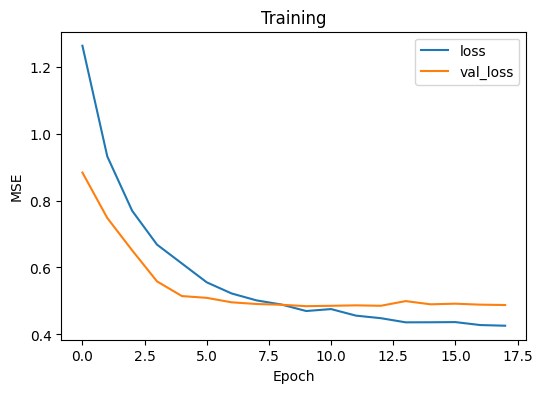

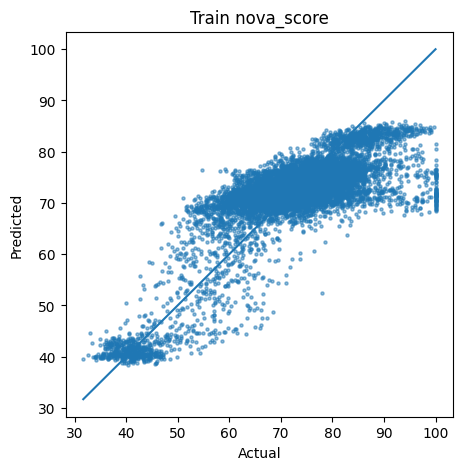

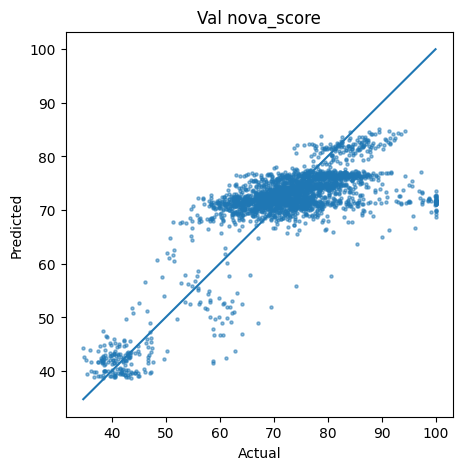

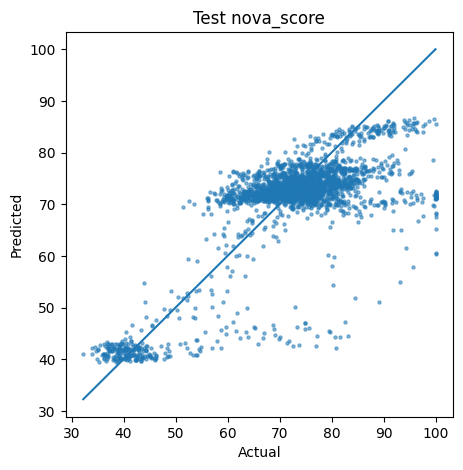

Saved outputs to: /mnt/data/lstm_outputs_nova


In [ ]:
# ===== Multivariate LSTM for nova_score with correlation-weighted features =====
# End-to-end: load -> prep -> sequences -> worker-safe split -> scale -> corr weights -> train -> eval -> save

import os, json, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, LayerNormalization, GaussianNoise
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import regularizers
from sklearn.preprocessing import StandardScaler

# ----------------------------- Config -----------------------------
DATA_PATH      = "final_nova_dataset_65_35.csv"
TARGET         = "nova_score"
DROP_COLS      = ["nova_prev_score","nova_score"]  # drop other scores
SEQ_LEN        = 12          # timesteps per sample
HORIZON        = 1           # predict next step
TEST_FRACTION  = 0.15        # split by worker (leakage-safe)
VAL_FRACTION   = 0.15
RANDOM_SEED    = 42

# Correlation weighting (train-only)
CORR_DECAY     = 0.7         # recency weight per timestep (closer to 1 => more recent emphasized)
CORR_POWER     = 1.0         # |corr|^power (0.5 softer, 2.0 stronger)
EPS            = 1e-6

# Model & training
L2_REG         = 1e-4
LR             = 3e-4
EPOCHS         = 80
BATCH_SIZE     = 512
OUT_DIR        = "/mnt/data/lstm_outputs_nova"
os.makedirs(OUT_DIR, exist_ok=True)

np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

# ----------------------------- Load & prep -----------------------------
df = pd.read_csv(DATA_PATH).copy()

# Ensure required columns
missing = {"worker_id", "week", TARGET} - set(df.columns)
if missing:
    raise ValueError(f"Dataset missing required columns: {missing}")

# Drop unwanted columns (but never the target)
DROP_COLS = [c for c in DROP_COLS if c != TARGET and c in df.columns]
df = df.drop(columns=DROP_COLS, errors="ignore")

# Order by worker/time to build sequences
df = df.sort_values(["worker_id", "week"]).reset_index(drop=True)

# Feature split (exclude id/time/target from features)
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in df.columns if c not in num_cols]
exclude  = {"worker_id", "week", TARGET}
feat_num = [c for c in num_cols if c not in exclude]
feat_cat = [c for c in cat_cols if c not in exclude]

# One-hot categoricals + concat
X_df = pd.concat([df[feat_num], pd.get_dummies(df[feat_cat], drop_first=False)], axis=1)
ids   = df["worker_id"].values
weeks = df["week"].values
y     = df[TARGET].values.astype(float)

print(f"Features (flat): {X_df.shape} | Numeric={len(feat_num)} | Categorical expanded={X_df.shape[1]-len(feat_num)}")
print("Dropped columns:", DROP_COLS)

# ----------------------------- Build sequences per worker -----------------------------
def build_sequences_per_worker(X, y, ids, times, L=SEQ_LEN, H=HORIZON):
    Xs, Ys, Ws = [], [], []
    n = len(ids)
    i = 0
    while i < n:
        wid = ids[i]; j = i
        while j < n and ids[j] == wid:
            j += 1
        segX = X[i:j].astype(float)
        segY = y[i:j].astype(float)
        # rolling windows
        for k in range(0, len(segX) - L - H + 1):
            Xs.append(segX[k:k+L])
            Ys.append(segY[k+L+H-1])
            Ws.append(wid)
        i = j
    return np.array(Xs), np.array(Ys), np.array(Ws)

X_all, y_all, wid_all = build_sequences_per_worker(X_df.values, y, ids, weeks, SEQ_LEN, HORIZON)
print("Sequences:", X_all.shape, "| Targets:", y_all.shape, "| Unique workers in sequences:", len(pd.unique(wid_all)))

# ----------------------------- Worker-safe split (avoid leakage) -----------------------------
uniq_workers = pd.unique(wid_all)
rng = np.random.RandomState(RANDOM_SEED)
rng.shuffle(uniq_workers)
n_test = int(round(TEST_FRACTION * len(uniq_workers)))
n_val  = int(round(VAL_FRACTION  * len(uniq_workers)))

test_workers  = set(uniq_workers[:n_test])
val_workers   = set(uniq_workers[n_test:n_test+n_val])
train_workers = set(uniq_workers[n_test+n_val:])

def mask_by_workers(worker_set):
    return np.array([w in worker_set for w in wid_all])

mtr, mva, mte = mask_by_workers(train_workers), mask_by_workers(val_workers), mask_by_workers(test_workers)
Xtr, ytr = X_all[mtr], y_all[mtr]
Xva, yva = X_all[mva], y_all[mva]
Xte, yte = X_all[mte], y_all[mte]
print("Splits:", Xtr.shape, Xva.shape, Xte.shape)

# ----------------------------- Scale (train-only stats) -----------------------------
T, F = Xtr.shape[1], Xtr.shape[2]
Xtr_f = Xtr.reshape(-1, F)
Xva_f = Xva.reshape(-1, F)
Xte_f = Xte.reshape(-1, F)

x_scaler = StandardScaler().fit(Xtr_f)
XtrS = x_scaler.transform(Xtr_f).reshape(-1, T, F)
XvaS = x_scaler.transform(Xva_f).reshape(-1, T, F)
XteS = x_scaler.transform(Xte_f).reshape(-1, T, F)

y_scaler = StandardScaler().fit(ytr.reshape(-1, 1))
ytrS = y_scaler.transform(ytr.reshape(-1, 1)).ravel()
yvaS = y_scaler.transform(yva.reshape(-1, 1)).ravel()
yteS = y_scaler.transform(yte.reshape(-1, 1)).ravel()

# ----------------------------- Correlation-weighted features (train-only) -----------------------------
def corr_feature_weights(X_trS, y_trS, decay=CORR_DECAY, power=CORR_POWER, eps=EPS):
    S, T, F = X_trS.shape
    # recency weights over time steps (sum=1)
    w_t = np.array([decay**(T-1-t) for t in range(T)], dtype=float)
    w_t = w_t / w_t.sum()

    r = np.zeros(F, dtype=float)
    for j in range(F):
        # per-timestep Pearson corr(feature_t, y)
        r_j_t = []
        for t in range(T):
            x = X_trS[:, t, j]
            sx = np.std(x)
            if sx < 1e-12:
                r_j_t.append(0.0)
            else:
                r_j_t.append(np.corrcoef(x, y_trS)[0, 1])
        r[j] = np.sum(w_t * np.nan_to_num(r_j_t))

    # positive weights; normalize to mean 1.0
    w = (np.abs(r) ** power) + eps
    w = w / w.mean()
    return w, r

w_feat, r_feat = corr_feature_weights(XtrS, ytrS, decay=CORR_DECAY, power=CORR_POWER)
feat_names = X_df.columns.tolist()
top_idx = np.argsort(-np.abs(r_feat))[:20]
print("Top 20 features by |corr| with nova_score (train):")
for i in top_idx:
    print(f"{feat_names[i]:30s}  corr={r_feat[i]: .4f}  weight={w_feat[i]: .3f}")

# Apply weights to all splits (broadcast over feature dim)
XtrS = XtrS * w_feat
XvaS = XvaS * w_feat
XteS = XteS * w_feat

# ----------------------------- Model (regularized to reduce overfitting) -----------------------------
def build_model(T, F, l2=L2_REG, lr=LR):
    m = Sequential([
        GaussianNoise(0.01, input_shape=(T, F)),
        LSTM(64, return_sequences=True, recurrent_dropout=0.15, kernel_regularizer=regularizers.l2(l2)),
        LayerNormalization(),
        Dropout(0.35),
        LSTM(32, recurrent_dropout=0.15, kernel_regularizer=regularizers.l2(l2)),
        LayerNormalization(),
        Dropout(0.35),
        Dense(16, activation="relu", kernel_regularizer=regularizers.l2(l2)),
        Dense(1)
    ])
    opt = tf.keras.optimizers.Adam(learning_rate=lr, clipnorm=1.0)
    m.compile(optimizer=opt,
              loss="mse",
              metrics=[tf.keras.metrics.MeanAbsoluteError(name="mae"),
                       tf.keras.metrics.RootMeanSquaredError(name="rmse")])
    return m

model = build_model(T, F)
model.summary()

callbacks = [
    EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=4, min_lr=1e-6, verbose=1),
    ModelCheckpoint(os.path.join(OUT_DIR, "best.keras"), monitor="val_loss", save_best_only=True, verbose=1)
]

history = model.fit(
    XtrS, ytrS,
    validation_data=(XvaS, yvaS),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=True,
    verbose=1,
    callbacks=callbacks
)

# ----------------------------- Evaluation -----------------------------
def invert(scaler, arr):
    return scaler.inverse_transform(arr.reshape(-1, 1)).ravel()

def evaluate_set(name, mdl, X, yS, y_scaler):
    pS = mdl.predict(X, verbose=0).ravel()
    y  = invert(y_scaler, yS)
    p  = invert(y_scaler, pS)
    mae = float(np.mean(np.abs(y - p)))
    rmse = float(np.sqrt(np.mean((y - p) ** 2)))
    print(f"{name:5s}  MAE={mae:.3f}  RMSE={rmse:.3f}")
    return y, p

ytr_true, ytr_pred = evaluate_set("Train", model, XtrS, ytrS, y_scaler)
yva_true, yva_pred = evaluate_set("Val",   model, XvaS, yvaS, y_scaler)
yte_true, yte_pred = evaluate_set("Test",  model, XteS, yteS, y_scaler)

# ----------------------------- Plots -----------------------------
def plot_history(h):
    if not h: return
    plt.figure(figsize=(6,4))
    plt.plot(h.history["loss"], label="loss")
    plt.plot(h.history["val_loss"], label="val_loss")
    plt.xlabel("Epoch"); plt.ylabel("MSE"); plt.title("Training"); plt.legend(); plt.show()

def plot_scatter(y, p, title):
    if y is None: return
    plt.figure(figsize=(5,5))
    plt.scatter(y, p, s=5, alpha=0.5)
    lim = [min(y.min(), p.min()), max(y.max(), p.max())]
    plt.plot(lim, lim)
    plt.xlabel("Actual"); plt.ylabel("Predicted"); plt.title(title); plt.show()

plot_history(history)
plot_scatter(ytr_true, ytr_pred, "Train nova_score")
plot_scatter(yva_true, yva_pred, "Val nova_score")
plot_scatter(yte_true, yte_pred, "Test nova_score")

# ----------------------------- Save artifacts -----------------------------
import pickle
with open(os.path.join(OUT_DIR, "x_scaler.pkl"), "wb") as f: pickle.dump(x_scaler, f)
with open(os.path.join(OUT_DIR, "y_scaler.pkl"), "wb") as f: pickle.dump(y_scaler, f)
np.save(os.path.join(OUT_DIR, "feature_weights.npy"), w_feat)

try:
    model.save(os.path.join(OUT_DIR, "lstm_nova_score.keras"))
except Exception as e:
    print("Model save error:", e)


meta = {
    "target": TARGET,
    "seq_len": SEQ_LEN,
    "horizon": HORIZON,
    "n_features": int(F),
    "numeric_features": feat_num,
    "categorical_features": feat_cat,
    "dropped_columns": DROP_COLS,
    "corr_decay": CORR_DECAY,
    "corr_power": CORR_POWER,
    "l2_reg": L2_REG,
    "learning_rate": LR,
    "batch_size": BATCH_SIZE,
    "epochs": EPOCHS,
}
with open(os.path.join(OUT_DIR, "meta.json"), "w") as f:
    json.dump(meta, f, indent=2)

print("Saved outputs to:", OUT_DIR)


In [ ]:
# === Save the whole pipeline into one PKL ===
# expects: model, x_scaler, y_scaler, w_feat, X_df, SEQ_LEN, HORIZON, TARGET

import pickle, numpy as np, json

bundle = {
    "model_json": model.to_json(),
    "model_weights": model.get_weights(),  # list of numpy arrays
    "x_scaler": x_scaler,
    "y_scaler": y_scaler,
    "feature_columns": X_df.columns.tolist(),  # exact one-hot order
    "w_feat": np.asarray(w_feat, dtype=np.float32),
    "meta": {
        "target": TARGET,
        "seq_len": int(SEQ_LEN),
        "horizon": int(HORIZON),
        "n_features": int(X_df.shape[1]),
        "notes": "Standardize with x_scaler, then multiply by w_feat before predict"
    },
}

PKL_PATH = "/mnt/data/lstm_nova_bundle.pkl"
with open(PKL_PATH, "wb") as f:
    pickle.dump(bundle, f, protocol=pickle.HIGHEST_PROTOCOL)

print("Saved:", PKL_PATH)

Saved: /mnt/data/lstm_nova_bundle.pkl


Features (flat): (19126, 26) | Numeric=13 | Categorical expanded=13
Dropped columns: ['nova_prev_score']
Sequences: (16726, 12, 26) | Targets: (16726,) | Unique workers in sequences: 200
Splits: (11682, 12, 26) (2515, 12, 26) (2529, 12, 26)
Top 20 features by |corr| with nova_score (train):
earnings                        corr= 0.6022  weight= 4.390
jobs_completed                  corr= 0.4439  weight= 3.236
gap_days                        corr=-0.4157  weight= 3.030
transaction_count               corr= 0.3902  weight= 2.845
hours_worked                    corr= 0.3655  weight= 2.664
avg_job_value                   corr= 0.2247  weight= 1.638
worker_type_merchant            corr= 0.2024  weight= 1.475
worker_type_delivery            corr=-0.1749  weight= 1.275
repeat_client_share             corr= 0.1331  weight= 0.971
partner_tier_gold               corr= 0.1007  weight= 0.734
partner_tier_silver             corr=-0.0869  weight= 0.633
cancellation_rate               corr=-0.0604  we

/usr/local/lib/python3.12/dist-packages/keras/src/layers/regularization/gaussian_noise.py:29: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gaussian_noise_1                │ (None, 12, 26)         │             0 │
│ (GaussianNoise)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 12, 64)         │        23,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_2           │ (None, 12, 64)         │           128 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 12, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_3           │ (None, 32)             │            64 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36,449 (142.38 KB)

 Trainable params: 36,449 (142.38 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/80
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - loss: 1.6391 - mae: 0.9539 - rmse: 1.2147
Epoch 1: val_loss improved from inf to 0.98278, saving model to /mnt/data/lstm_outputs_nova/best.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 12s 181ms/step - loss: 1.6281 - mae: 0.9512 - rmse: 1.2117 - val_loss: 0.9828 - val_mae: 0.7156 - val_rmse: 0.9837 - learning_rate: 3.0000e-04
Epoch 2/80
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 1.0426 - mae: 0.7811 - rmse: 1.0161
Epoch 2: val_loss improved from 0.98278 to 0.82809, saving model to /mnt/data/lstm_outputs_nova/best.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - loss: 1.0399 - mae: 0.7805 - rmse: 1.0153 - val_loss: 0.8281 - val_mae: 0.6466 - val_rmse: 0.9016 - learning_rate: 3.0000e-04
Epoch 3/80
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.9234 - mae: 0.7131 - rmse: 0.9283
Epoch 3: val_loss improved from 0.82809 to 0.74780, saving model to /mnt/data/lstm_outputs_nova/best.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - loss: 0.9201 - ma

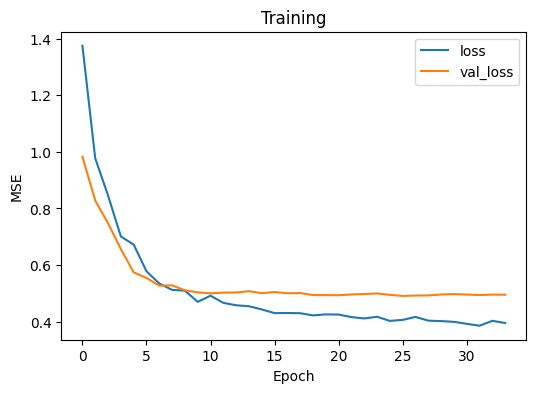

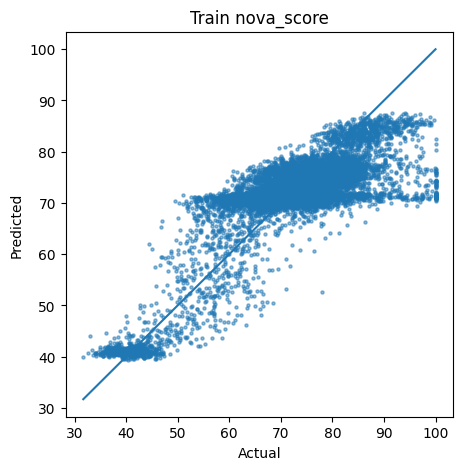

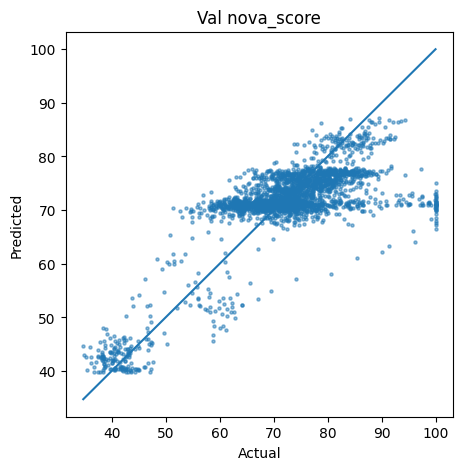

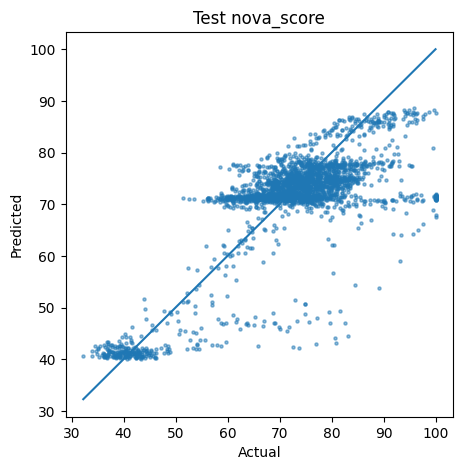

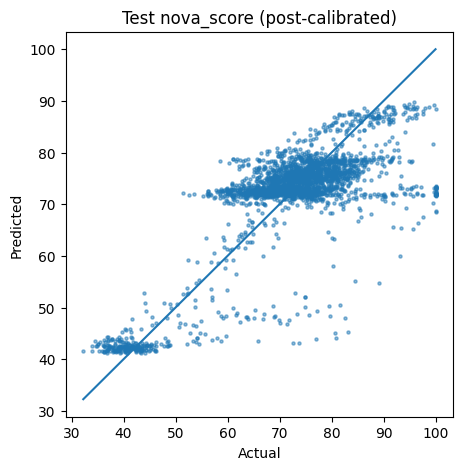

Saved outputs to: /mnt/data/lstm_outputs_nova


In [ ]:
# ===== Multivariate LSTM for nova_score with correlation-weighted features =====
# Extended with bias mitigation: reweighing + group metrics + post-calibration

import os, json, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, LayerNormalization, GaussianNoise
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import regularizers
from sklearn.preprocessing import StandardScaler

# ----------------------------- Config -----------------------------
DATA_PATH      = "final_nova_dataset_65_35.csv"
TARGET         = "nova_score"
DROP_COLS      = [ "nova_prev_score", "credit_score"]  # drop other scores
SEQ_LEN        = 12          # timesteps per sample
HORIZON        = 1           # predict next step
TEST_FRACTION  = 0.15        # split by worker (leakage-safe)
VAL_FRACTION   = 0.15
RANDOM_SEED    = 42

# Correlation weighting (train-only)
CORR_DECAY     = 0.7         # recency weight per timestep (closer to 1 => more recent emphasized)
CORR_POWER     = 1.0         # |corr|^power (0.5 softer, 2.0 stronger)
EPS            = 1e-6

# Model & training
L2_REG         = 1e-4
LR             = 3e-4
EPOCHS         = 80
BATCH_SIZE     = 512
OUT_DIR        = "/mnt/data/lstm_outputs_nova"
os.makedirs(OUT_DIR, exist_ok=True)

# Fairness settings
PROTECTED_KEYS = ['gender', 'region']   # attributes to protect / balance on (must exist in your df)
N_LABEL_BINS   = 5                      # bins to discretize continuous target for reweighing
APPLY_POST_CALIB = True                 # compute val offsets and apply to test preds

np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

# ----------------------------- Load & prep -----------------------------
df = pd.read_csv(DATA_PATH).copy()

# Ensure required columns
missing = {"worker_id", "week", TARGET} - set(df.columns)
if missing:
    raise ValueError(f"Dataset missing required columns: {missing}")

# Drop unwanted columns (but never the target)
DROP_COLS = [c for c in DROP_COLS if c != TARGET and c in df.columns]
df = df.drop(columns=DROP_COLS, errors="ignore")

# Order by worker/time to build sequences
df = df.sort_values(["worker_id", "week"]).reset_index(drop=True)

# Feature split (exclude id/time/target from features)
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in df.columns if c not in num_cols]
exclude  = {"worker_id", "week", TARGET}
feat_num = [c for c in num_cols if c not in exclude]
feat_cat = [c for c in cat_cols if c not in exclude]

# One-hot categoricals + concat
X_df = pd.concat([df[feat_num], pd.get_dummies(df[feat_cat], drop_first=False)], axis=1)
ids   = df["worker_id"].values
weeks = df["week"].values
y     = df[TARGET].values.astype(float)

print(f"Features (flat): {X_df.shape} | Numeric={len(feat_num)} | Categorical expanded={X_df.shape[1]-len(feat_num)}")
print("Dropped columns:", DROP_COLS)

# ----------------------------- Build sequences per worker -----------------------------
def build_sequences_per_worker(X, y, ids, times, L=SEQ_LEN, H=HORIZON):
    Xs, Ys, Ws = [], [], []
    n = len(ids)
    i = 0
    while i < n:
        wid = ids[i]; j = i
        while j < n and ids[j] == wid:
            j += 1
        segX = X[i:j].astype(float)
        segY = y[i:j].astype(float)
        # rolling windows
        for k in range(0, len(segX) - L - H + 1):
            Xs.append(segX[k:k+L])
            Ys.append(segY[k+L+H-1])
            Ws.append(wid)
        i = j
    return np.array(Xs), np.array(Ys), np.array(Ws)

X_all, y_all, wid_all = build_sequences_per_worker(X_df.values, y, ids, weeks, SEQ_LEN, HORIZON)
print("Sequences:", X_all.shape, "| Targets:", y_all.shape, "| Unique workers in sequences:", len(pd.unique(wid_all)))

# ----------------------------- Worker-safe split (avoid leakage) -----------------------------
uniq_workers = pd.unique(wid_all)
rng = np.random.RandomState(RANDOM_SEED)
rng.shuffle(uniq_workers)
n_test = int(round(TEST_FRACTION * len(uniq_workers)))
n_val  = int(round(VAL_FRACTION  * len(uniq_workers)))

test_workers  = set(uniq_workers[:n_test])
val_workers   = set(uniq_workers[n_test:n_test+n_val])
train_workers = set(uniq_workers[n_test+n_val:])

def mask_by_workers(worker_set):
    return np.array([w in worker_set for w in wid_all])

mtr, mva, mte = mask_by_workers(train_workers), mask_by_workers(val_workers), mask_by_workers(test_workers)
Xtr, ytr = X_all[mtr], y_all[mtr]
Xva, yva = X_all[mva], y_all[mva]
Xte, yte = X_all[mte], y_all[mte]
print("Splits:", Xtr.shape, Xva.shape, Xte.shape)

# ----------------------------- Scale (train-only stats) -----------------------------
T, F = Xtr.shape[1], Xtr.shape[2]
Xtr_f = Xtr.reshape(-1, F)
Xva_f = Xva.reshape(-1, F)
Xte_f = Xte.reshape(-1, F)

x_scaler = StandardScaler().fit(Xtr_f)
XtrS = x_scaler.transform(Xtr_f).reshape(-1, T, F)
XvaS = x_scaler.transform(Xva_f).reshape(-1, T, F)
XteS = x_scaler.transform(Xte_f).reshape(-1, T, F)

y_scaler = StandardScaler().fit(ytr.reshape(-1, 1))
ytrS = y_scaler.transform(ytr.reshape(-1, 1)).ravel()
yvaS = y_scaler.transform(yva.reshape(-1, 1)).ravel()
yteS = y_scaler.transform(yte.reshape(-1, 1)).ravel()

# ----------------------------- Correlation-weighted features (train-only) -----------------------------
def corr_feature_weights(X_trS, y_trS, decay=CORR_DECAY, power=CORR_POWER, eps=EPS):
    S, T, F = X_trS.shape
    # recency weights over time steps (sum=1)
    w_t = np.array([decay**(T-1-t) for t in range(T)], dtype=float)
    w_t = w_t / w_t.sum()

    r = np.zeros(F, dtype=float)
    for j in range(F):
        # per-timestep Pearson corr(feature_t, y)
        r_j_t = []
        for t in range(T):
            x = X_trS[:, t, j]
            sx = np.std(x)
            if sx < 1e-12:
                r_j_t.append(0.0)
            else:
                r_j_t.append(np.corrcoef(x, y_trS)[0, 1])
        r[j] = np.sum(w_t * np.nan_to_num(r_j_t))

    # positive weights; normalize to mean 1.0
    w = (np.abs(r) ** power) + eps
    w = w / w.mean()
    return w, r

w_feat, r_feat = corr_feature_weights(XtrS, ytrS, decay=CORR_DECAY, power=CORR_POWER)
feat_names = X_df.columns.tolist()
top_idx = np.argsort(-np.abs(r_feat))[:20]
print("Top 20 features by |corr| with nova_score (train):")
for i in top_idx:
    print(f"{feat_names[i]:30s}  corr={r_feat[i]: .4f}  weight={w_feat[i]: .3f}")

# Apply weights to all splits (broadcast over feature dim)
XtrS = XtrS * w_feat
XvaS = XvaS * w_feat
XteS = XteS * w_feat

# ----------------------------- FAIRNESS: worker metadata & helper functions -----------------------------
# Build worker-level metadata lookup (last observed row per worker in df)
available_protected = [k for k in PROTECTED_KEYS if k in df.columns]
if len(available_protected) == 0:
    print("WARNING: No protected attributes (gender/region/...) found in dataframe. Skipping reweighing.")
worker_meta = {}
if len(available_protected) > 0:
    # use last observation per worker to get stable attributes
    meta_df = df.groupby('worker_id').last()
    # ensure the keys exist
    for wid, row in meta_df.iterrows():
        worker_meta[int(wid)] = {k: row[k] if k in row.index else None for k in available_protected}

def seq_worker_attributes(wid_array):
    """Return list of dicts of worker-level attrs aligned with sequence arrays."""
    out = []
    for w in wid_array:
        w_int = int(w)
        if w_int in worker_meta:
            out.append(worker_meta[w_int])
        else:
            # fallback: unknown worker -> dict of None
            out.append({k: None for k in available_protected})
    return out

def group_metrics(y_true, y_pred, wids, group_key='gender'):
    """Compute group-wise mean prediction, MAE, RMSE, counts."""
    meta = seq_worker_attributes(wids)
    groups = {}
    for yt, yp, m in zip(y_true, y_pred, meta):
        g = m.get(group_key, None)
        if g is None:
            g = "UNKNOWN"
        if g not in groups:
            groups[g] = {'y':[], 'p':[]}
        groups[g]['y'].append(yt)
        groups[g]['p'].append(yp)
    out = {}
    all_y = np.concatenate([np.array(groups[g]['y']) for g in groups])
    overall_mae = np.mean(np.abs(all_y - np.concatenate([np.array(groups[g]['p']) for g in groups])))
    for g, data in groups.items():
        y = np.array(data['y']); p = np.array(data['p'])
        mae = float(np.mean(np.abs(y-p))) if len(y) else np.nan
        rmse = float(np.sqrt(np.mean((y-p)**2))) if len(y) else np.nan
        mean_pred = float(np.mean(p)) if len(p) else np.nan
        mean_true = float(np.mean(y)) if len(y) else np.nan
        out[g] = {
            'count': len(y),
            'mean_true': mean_true,
            'mean_pred': mean_pred,
            'mae': mae,
            'rmse': rmse,
            'mae_vs_overall': mae - overall_mae
        }
    return out

def print_group_metrics(metrics, title="Group metrics"):
    print("===", title, "===")
    for g,v in metrics.items():
        print(f"{g:15s}  n={v['count']:6d}  mean_true={v['mean_true']:.3f}  mean_pred={v['mean_pred']:.3f}  mae={v['mae']:.3f}  rmse={v['rmse']:.3f}  mae_diff={v['mae_vs_overall']:.3f}")

# ----------------------------- Reweighing: compute sample weights for training sequences ----------
sample_weights = None
if len(available_protected) > 0:
    # choose protected keys to use (subset of available_protected)
    used_protected = available_protected  # could choose subset
    # training sequence worker ids and true labels (unscaled)
    train_wids = wid_all[mtr]
    train_y = ytr  # already defined as unscaled targets
    # group id per sequence
    def group_id_for_seq(wid):
        m = worker_meta.get(int(wid), {k:None for k in used_protected})
        return tuple(m.get(k, None) for k in used_protected)

    group_ids = np.array([group_id_for_seq(w) for w in train_wids], dtype=object)

    # discretize labels into bins (based on training true labels)
    n_label_bins = max(2, N_LABEL_BINS)
    bin_edges = np.quantile(train_y, np.linspace(0,1,n_label_bins+1))
    # digitize into 0..n_label_bins-1
    bin_idx = np.digitize(train_y, bin_edges[1:-1], right=True)

    group_ids = np.array(group_ids).flatten()
    bin_idx = np.array(bin_idx).flatten()

    # compute counts per (group, bin)
    counts = {}
    for g,b in zip(group_ids, bin_idx):
        counts.setdefault(g, {}).setdefault(b, 0)
        counts[g][b] += 1

    # unnormalized weight = 1 / count(group, bin)
    sample_weights = np.zeros(len(train_y), dtype=float)
    for i,(g,b) in enumerate(zip(group_ids, bin_idx)):
        c = counts[g][b]
        sample_weights[i] = 1.0 / (c + 1e-12)

    # normalize to mean 1
    sample_weights = sample_weights / sample_weights.mean()
    print("Sample weights computed for reweighing. stats: mean", sample_weights.mean(), "min", sample_weights.min(), "max", sample_weights.max())
else:
    print("Skipping reweighing because no protected attributes available.")

# ----------------------------- Model (regularized to reduce overfitting) -----------------------------
def build_model(T, F, l2=L2_REG, lr=LR):
    m = Sequential([
        GaussianNoise(0.01, input_shape=(T, F)),
        LSTM(64, return_sequences=True, recurrent_dropout=0.15, kernel_regularizer=regularizers.l2(l2)),
        LayerNormalization(),
        Dropout(0.35),
        LSTM(32, recurrent_dropout=0.15, kernel_regularizer=regularizers.l2(l2)),
        LayerNormalization(),
        Dropout(0.35),
        Dense(16, activation="relu", kernel_regularizer=regularizers.l2(l2)),
        Dense(1)
    ])
    opt = tf.keras.optimizers.Adam(learning_rate=lr, clipnorm=1.0)
    m.compile(optimizer=opt,
              loss="mse",
              metrics=[tf.keras.metrics.MeanAbsoluteError(name="mae"),
                       tf.keras.metrics.RootMeanSquaredError(name="rmse")])
    return m

model = build_model(T, F)
model.summary()

callbacks = [
    EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=4, min_lr=1e-6, verbose=1),
    ModelCheckpoint(os.path.join(OUT_DIR, "best.keras"), monitor="val_loss", save_best_only=True, verbose=1)
]

# ----------------------------- Train (with sample_weight if computed) -----------------------------
fit_kwargs = dict(
    x = XtrS,
    y = ytrS,
    validation_data = (XvaS, yvaS),
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    shuffle = True,
    verbose = 1,
    callbacks = callbacks
)
if sample_weights is not None:
    fit_kwargs['sample_weight'] = sample_weights

history = model.fit(**fit_kwargs)

# ----------------------------- Evaluation -----------------------------
def invert(scaler, arr):
    return scaler.inverse_transform(arr.reshape(-1, 1)).ravel()

def evaluate_set(name, mdl, X, yS, y_scaler):
    pS = mdl.predict(X, verbose=0).ravel()
    y  = invert(y_scaler, yS)
    p  = invert(y_scaler, pS)
    mae = float(np.mean(np.abs(y - p)))
    rmse = float(np.sqrt(np.mean((y - p) ** 2)))
    print(f"{name:5s}  MAE={mae:.3f}  RMSE={rmse:.3f}")
    return y, p

ytr_true, ytr_pred = evaluate_set("Train", model, XtrS, ytrS, y_scaler)
yva_true, yva_pred = evaluate_set("Val",   model, XvaS, yvaS, y_scaler)
yte_true, yte_pred = evaluate_set("Test",  model, XteS, yteS, y_scaler)

# ----------------------------- Group metrics BEFORE post-calibration -----------------------------
if len(available_protected) > 0:
    # Show by each protected key
    for key in available_protected:
        print()
        tr_g = group_metrics(ytr_true, ytr_pred, wid_all[mtr], group_key=key)
        va_g = group_metrics(yva_true, yva_pred, wid_all[mva], group_key=key)
        te_g = group_metrics(yte_true, yte_pred, wid_all[mte], group_key=key)
        print_group_metrics(tr_g, f"Train ({key})")
        print_group_metrics(va_g, f"Val   ({key})")
        print_group_metrics(te_g, f"Test  ({key})")

# ----------------------------- Post-processing calibration (per-group offset) ----------
adjusted_yte_pred = yte_pred.copy()
if APPLY_POST_CALIB and len(available_protected) > 0:
    print("\nComputing per-group offsets on validation set (post-calibration)...")
    # compute offsets = mean_pred - mean_true on VAL (for each protected key value)
    val_meta = seq_worker_attributes(wid_all[mva])
    offsets = {}  # offsets[key][group_value] = offset
    for key in available_protected:
        offsets[key] = {}
        # gather groups present in validation
        groups_present = sorted(set([m.get(key, "UNKNOWN") for m in val_meta]))
        for g in groups_present:
            idxs = [i for i,m in enumerate(val_meta) if m.get(key, "UNKNOWN")==g]
            if len(idxs) == 0:
                continue
            mean_pred = float(np.mean(yva_pred[idxs]))
            mean_true = float(np.mean(yva_true[idxs]))
            offsets[key][g] = mean_pred - mean_true

    # apply offsets to TEST predictions: subtract offset to align means
    test_meta = seq_worker_attributes(wid_all[mte])
    for i,m in enumerate(test_meta):
        # combine offsets from multiple keys by averaging offsets present (simple approach)
        offs_vals = []
        for key in available_protected:
            g = m.get(key, "UNKNOWN")
            if g in offsets.get(key, {}):
                offs_vals.append(offsets[key][g])
        if len(offs_vals) > 0:
            avg_off = float(np.mean(offs_vals))
            adjusted_yte_pred[i] = adjusted_yte_pred[i] - avg_off

    # Evaluate after calibration
    print("\nEvaluation after post-calibration (Test):")
    mae_post = float(np.mean(np.abs(yte_true - adjusted_yte_pred)))
    rmse_post = float(np.sqrt(np.mean((yte_true - adjusted_yte_pred)**2)))
    print(f"Test (post-calib)  MAE={mae_post:.3f}  RMSE={rmse_post:.3f}")

    # Group metrics after post-calibration
    for key in available_protected:
        te_g_post = group_metrics(yte_true, adjusted_yte_pred, wid_all[mte], group_key=key)
        print_group_metrics(te_g_post, f"Test ({key}) after post-calibration")
else:
    print("Post-calibration skipped (either disabled or no protected attributes).")

# ----------------------------- Plots -----------------------------
def plot_history(h):
    if not h: return
    plt.figure(figsize=(6,4))
    plt.plot(h.history["loss"], label="loss")
    plt.plot(h.history["val_loss"], label="val_loss")
    plt.xlabel("Epoch"); plt.ylabel("MSE"); plt.title("Training"); plt.legend(); plt.show()

def plot_scatter(y, p, title):
    if y is None: return
    plt.figure(figsize=(5,5))
    plt.scatter(y, p, s=5, alpha=0.5)
    lim = [min(y.min(), p.min()), max(y.max(), p.max())]
    plt.plot(lim, lim)
    plt.xlabel("Actual"); plt.ylabel("Predicted"); plt.title(title); plt.show()

plot_history(history)
plot_scatter(ytr_true, ytr_pred, "Train nova_score")
plot_scatter(yva_true, yva_pred, "Val nova_score")
plot_scatter(yte_true, yte_pred, "Test nova_score")
if APPLY_POST_CALIB and len(available_protected) > 0:
    plot_scatter(yte_true, adjusted_yte_pred, "Test nova_score (post-calibrated)")

# ----------------------------- Save artifacts -----------------------------
import pickle
with open(os.path.join(OUT_DIR, "x_scaler.pkl"), "wb") as f: pickle.dump(x_scaler, f)
with open(os.path.join(OUT_DIR, "y_scaler.pkl"), "wb") as f: pickle.dump(y_scaler, f)
np.save(os.path.join(OUT_DIR, "feature_weights.npy"), w_feat)

try:
    model.save(os.path.join(OUT_DIR, "lstm_nova_score.keras"))
except Exception as e:
    print("Model save error:", e)


meta = {
    "target": TARGET,
    "seq_len": SEQ_LEN,
    "horizon": HORIZON,
    "n_features": int(F),
    "numeric_features": feat_num,
    "categorical_features": feat_cat,
    "dropped_columns": DROP_COLS,
    "corr_decay": CORR_DECAY,
    "corr_power": CORR_POWER,
    "l2_reg": L2_REG,
    "learning_rate": LR,
    "batch_size": BATCH_SIZE,
    "epochs": EPOCHS,
    "fairness": {
        "protected_keys": available_protected,
        "reweighing_label_bins": N_LABEL_BINS,
        "post_calibration": APPLY_POST_CALIB
    }
}
with open(os.path.join(OUT_DIR, "meta.json"), "w") as f:
    json.dump(meta, f, indent=2)

print("Saved outputs to:", OUT_DIR)


In [ ]:
from sklearn.metrics import r2_score

def evaluate_set(name, mdl, X, yS, y_scaler):
    pS = mdl.predict(X, verbose=0).ravel()
    y  = y_scaler.inverse_transform(yS.reshape(-1,1)).ravel()
    p  = y_scaler.inverse_transform(pS.reshape(-1,1)).ravel()

    mae  = float(np.mean(np.abs(y - p)))
    rmse = float(np.sqrt(np.mean((y - p) ** 2)))
    r2   = r2_score(y, p)  # <-- add R² score

    print(f"{name:5s}  MAE={mae:.3f}  RMSE={rmse:.3f}  R2={r2:.3f}")
    return y, p

# Example usage
ytr_true, ytr_pred = evaluate_set("Train", model, XtrS, ytrS, y_scaler)
yva_true, yva_pred = evaluate_set("Val",   model, XvaS, yvaS, y_scaler)
yte_true, yte_pred = evaluate_set("Test",  model, XteS, yteS, y_scaler)


Train  MAE=4.748  RMSE=6.422  R2=0.643
Val    MAE=5.285  RMSE=7.419  R2=0.596
Test   MAE=5.545  RMSE=7.947  R2=0.597


In [ ]:
# === Save the whole pipeline into one PKL ===
# expects: model, x_scaler, y_scaler, w_feat, X_df, SEQ_LEN, HORIZON, TARGET

import pickle, numpy as np, json

bundle = {
    "model_json": model.to_json(),
    "model_weights": model.get_weights(),  # list of numpy arrays
    "x_scaler": x_scaler,
    "y_scaler": y_scaler,
    "feature_columns": X_df.columns.tolist(),  # exact one-hot order
    "w_feat": np.asarray(w_feat, dtype=np.float32),
    "meta": {
        "target": TARGET,
        "seq_len": int(SEQ_LEN),
        "horizon": int(HORIZON),
        "n_features": int(X_df.shape[1]),
        "notes": "Standardize with x_scaler, then multiply by w_feat before predict"
    },
}

PKL_PATH = "/mnt/data/lstm_nova_bundle.pkl"
with open(PKL_PATH, "wb") as f:
    pickle.dump(bundle, f, protocol=pickle.HIGHEST_PROTOCOL)


print("Saved:", PKL_PATH)


Saved: /mnt/data/lstm_nova_bundle.pkl


In [ ]:
from google.colab import files

# Download the pickle file
files.download("/mnt/data/lstm_nova_bundle.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [15]:
import pandas as pd
import numpy as np
import pickle, json, os, tensorflow as tf

# ------------------ Paths ------------------
MODEL_DIR = "/mnt/data/lstm_outputs_nova"
NEW_DATA  = "lightgbm_and_catboost_predicted_score.csv"

# ------------------ Load Artifacts ------------------
model = tf.keras.models.load_model(os.path.join(MODEL_DIR, "lstm_nova_score.keras"))
with open(os.path.join(MODEL_DIR, "x_scaler.pkl"), "rb") as f: x_scaler = pickle.load(f)
with open(os.path.join(MODEL_DIR, "y_scaler.pkl"), "rb") as f: y_scaler = pickle.load(f)
w_feat = np.load(os.path.join(MODEL_DIR, "feature_weights.npy"))
with open(os.path.join(MODEL_DIR, "meta.json")) as f: meta = json.load(f)

SEQ_LEN   = meta["seq_len"]
HORIZON   = meta["horizon"]

# ------------------ Load new dataset ------------------
df_new = pd.read_csv(NEW_DATA).copy()
df_new = df_new.sort_values(["worker_id","week"]).reset_index(drop=True)

# Keep original predicted columns
original_pred_cols = ["catboost_predicted_score", "light_gbm_predicted_score"]

# Drop only columns dropped in training
DROP_COLS = meta["dropped_columns"]
df_lstm = df_new.drop(columns=[c for c in DROP_COLS if c in df_new.columns], errors="ignore")

# ------------------ Feature processing ------------------
feat_num = meta["numeric_features"]
feat_cat = meta["categorical_features"]
X_new = pd.concat([df_lstm[feat_num], pd.get_dummies(df_lstm[feat_cat], drop_first=False)], axis=1)

ids   = df_lstm["worker_id"].values
weeks = df_lstm["week"].values

# ------------------ Build sequences per worker ------------------
def build_sequences_per_worker(X, ids, times, L=SEQ_LEN, H=HORIZON):
    Xs, Ws, week_seq = [], [], []
    n = len(ids)
    i = 0
    while i < n:
        wid = ids[i]; j = i
        while j < n and ids[j] == wid: j += 1
        segX = X[i:j].astype(float)
        segWeeks = times[i:j]
        for k in range(0, len(segX) - L - H + 1):
            Xs.append(segX[k:k+L])
            Ws.append(wid)
            week_seq.append(segWeeks[k+L+H-1])  # last week of sequence
        i = j
    return np.array(Xs), np.array(Ws), np.array(week_seq)

Xseq, wid_seq, week_seq = build_sequences_per_worker(X_new.values, ids, weeks, SEQ_LEN, HORIZON)

# ------------------ Scale + weight features ------------------
T, F = Xseq.shape[1], Xseq.shape[2]
Xseq_f = Xseq.reshape(-1, F)
XseqS = x_scaler.transform(Xseq_f).reshape(-1, T, F)
XseqS = XseqS * w_feat

# ------------------ Predict ------------------
y_predS = model.predict(XseqS, verbose=0).ravel()
y_pred  = y_scaler.inverse_transform(y_predS.reshape(-1,1)).ravel()

# ------------------ Attach predictions ------------------
pred_df = pd.DataFrame({
    "worker_id": wid_seq,
    "week": week_seq,
    "lstm_predicted_score": y_pred
})

# Merge LSTM predictions into original dataset
df_final = df_new.merge(pred_df, on=["worker_id", "week"], how="left")

# Forward-fill missing LSTM predictions per worker
df_final["lstm_predicted_score"] = df_final.groupby("worker_id")["lstm_predicted_score"].ffill()
# df_final["lstm_predicted_score"] = df_final["lstm_predicted_score"].fillna(60.0)
# Save final dataset
df_final.to_csv("all_models_predicted_score.csv", index=False)
print("Saved final dataset with LSTM, LightGBM, and CatBoost predictions to final_dataset_with_all_predictions.csv")


Saved final dataset with LSTM, LightGBM, and CatBoost predictions to final_dataset_with_all_predictions.csv


In [16]:
out_df = pd.read_csv("/content/all_models_predicted_score.csv")
print("\nFirst 5 rows of the saved CSV:")
print(out_df.head())



First 5 rows of the saved CSV:
   worker_id  week  age gender region partner_tier worker_type  earnings  \
0          0     4   33      M  North       silver    merchant   1416.67   
1          0     5   33      M  North       silver    merchant   1486.81   
2          0     6   33      M  North       silver    merchant   1608.10   
3          0     7   33      M  North       silver    merchant   1498.12   
4          0     8   33      M  North       silver    merchant   1779.19   

   jobs_completed  repeat_client_share  ...  customer_rating  \
0               7                 0.93  ...         4.916885   
1              12                 0.39  ...         4.529594   
2              14                 0.22  ...         2.103355   
3               8                 0.18  ...         3.917451   
4              11                 0.37  ...         4.457018   

   cancellation_rate  peak_hour_jobs_share  transaction_count  gap_days  \
0           0.070632                  0.68         

In [ ]:
from google.colab import files
files.download("new_with_predictions.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pickle

with open("/mnt/data/lstm_nova_bundle.pkl", "rb") as f:
    bundle = pickle.load(f)

# Inspect the type and keys/attributes
print(type(bundle))
if isinstance(bundle, dict):
    print(bundle.keys())
elif hasattr(bundle, "__dict__"):
    print(bundle.__dict__.keys())
else:
    print(bundle)


<class 'dict'>
dict_keys(['model_json', 'model_weights', 'x_scaler', 'y_scaler', 'feature_columns', 'w_feat', 'meta'])


In [ ]:
import pickle
import pandas as pd
import numpy as np
from tensorflow.keras.models import model_from_json

# ---------------- Load the bundle ----------------
with open("/mnt/data/lstm_nova_bundle.pkl", "rb") as f:
    bundle = pickle.load(f)

# ---------------- Reconstruct model ----------------
model = model_from_json(bundle['model_json'])
model.set_weights(bundle['model_weights'])

x_scaler = bundle['x_scaler']
y_scaler = bundle['y_scaler']
feature_columns = bundle['feature_columns']
w_feat = bundle['w_feat']
SEQ_LEN = bundle['meta']['seq_len']

# ---------------- Load your CSV ----------------
df = pd.read_csv("/content/both_models_predicted_results.csv")

# ---------------- One-hot encode categorical columns ----------------
# Extract categorical columns from feature_columns
cat_cols = [c.split('_')[0] for c in feature_columns if '_' in c]
cat_cols = list(set(cat_cols) & set(df.columns))  # only keep columns present in CSV

df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=False)

# ---------------- Reorder columns to match training ----------------
missing_cols = set(feature_columns) - set(df_encoded.columns)
for c in missing_cols:
    df_encoded[c] = 0  # add missing dummy columns

X_df = df_encoded[feature_columns].copy()
X_np = X_df.values.astype(float)

# ---------------- Build sequences ----------------
def build_sequences(X, seq_len):
    padding = np.zeros((seq_len-1, X.shape[1]))
    X_padded = np.vstack([padding, X])
    X_seq = []
    for i in range(seq_len-1, len(X_padded)):
        X_seq.append(X_padded[i-seq_len+1:i+1])
    return np.array(X_seq)

X_seq = build_sequences(X_np, SEQ_LEN)

# ---------------- Scale and apply feature weights ----------------
X_seq_flat = X_seq.reshape(-1, X_seq.shape[2])
X_seq_scaled = x_scaler.transform(X_seq_flat).reshape(X_seq.shape)
X_seq_scaled = X_seq_scaled * w_feat

# ---------------- Predict ----------------
y_pred_scaled = model.predict(X_seq_scaled, verbose=0).ravel()
y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()

# ---------------- Add predictions ----------------
df['lstm_predicted_score'] = y_pred

# ---------------- Save updated CSV ----------------
df.to_csv("your_data_with_lstm.csv", index=False)
print("Saved CSV with LSTM predictions!")


Saved CSV with LSTM predictions!


In [ ]:
import pickle

# Load LightGBM
with open("lightgbm_model.pkl", "rb") as f:
    lgb_model = pickle.load(f)

# Load CatBoost
with open("catboost_features.pkl", "rb") as f:
    cb_model = pickle.load(f)

# Load LSTM
with open("lstm_nova_bundlemodel.pkl", "rb") as f:
    lstm_model = pickle.load(f)


In [1]:
# Helper: get worker metadata (already in your code)
def seq_worker_attributes(wid_array, worker_meta, available_protected):
    out = []
    for w in wid_array:
        w_int = int(w)
        if w_int in worker_meta:
            out.append(worker_meta[w_int])
        else:
            out.append({k: None for k in available_protected})
    return out

# Example for gender and region
def group_metrics(y_true, y_pred, wids, worker_meta, group_key='gender'):
    meta = seq_worker_attributes(wids, worker_meta, [group_key])
    groups = {}
    for yt, yp, m in zip(y_true, y_pred, meta):
        g = m.get(group_key, None)
        if g is None:
            g = "UNKNOWN"
        if g not in groups:
            groups[g] = {'y':[], 'p':[]}
        groups[g]['y'].append(yt)
        groups[g]['p'].append(yp)
    out = {}
    for g, data in groups.items():
        y = pd.Series(data['y'])
        p = pd.Series(data['p'])
        out[g] = {
            'count': len(y),
            'mean_true': y.mean(),
            'mean_pred': p.mean(),
            'mae': (y - p).abs().mean(),
            'rmse': ((y - p) ** 2).mean() ** 0.5
        }
    return out

# Example usage (assuming you have yte_true, yte_pred, wid_all, mte, worker_meta)
gender_metrics = group_metrics(yte_true, yte_pred, wid_all[mte], worker_meta, group_key='gender')
region_metrics = group_metrics(yte_true, yte_pred, wid_all[mte], worker_meta, group_key='region')

print("Group-wise metrics by gender:")
for g, v in gender_metrics.items():
    print(f"{g}: count={v['count']}, mean_true={v['mean_true']:.2f}, mean_pred={v['mean_pred']:.2f}, MAE={v['mae']:.2f}, RMSE={v['rmse']:.2f}")

print("\nGroup-wise metrics by region:")
for g, v in region_metrics.items():
    print(f"{g}: count={v['count']}, mean_true={v['mean_true']:.2f}, mean_pred={v['mean_pred']:.2f}, MAE={v['mae']:.2f}, RMSE={v['rmse']:.2f}")

NameError: name 'yte_true' is not defined